# Speed dating data-set
## Discrimination-aware classification
#### Abdel K. Bokharouss - December 2017

<font color = "darkred"><b><i>Important note: a concrete goal of this assignment is, among other things, to give an extensive and qualitative comparison between a model which includes sensitive attributes and a model which excludes these sensitive attributes. Whether or not attributes are considered to be sensitive is subjective, and any decisions should, therefore, be supported by well-grounded arguments.</i></b>
<br>
<b><i>This brings us to our next important point: This assignment was discussed during the instruction of Wednesday (29-11). The conclusion was made that the models of our first assignment used no significant amount of sensitive attributes (this was no requirement of the first assignment) to facilitate a qualitve comparison. In consultation with the instructors present during that instruction, the choice is made to re-make the same model which was used in assignment 1, but with more sensitive attributes. This will facilitate a better comparison with the discrimination-aware model which uses no sensitive attributes</i></b></font>

### <font color="green">imports, preparation and configuration</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree, preprocessing, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# imports needed for the visualization and exportation of visualizations
import graphviz as gv # not included in the standard anaconda installer (can be found in the Anaconda Navigator)
import pydotplus # not included in anaconda at all (use pip/conda install pydotplus in cmd/conda prompt etc)
import io
from scipy import misc

In [3]:
from IPython.core.display import HTML # markdown cell styling and enabling/disabling warning messages
HTML("""
<style>
div.text_cell_render h1 {
font-size: 1.6em;
line-height:1.2em;
}

div.text_cell_render h2 { 
margin-bottom: -0.4em;
}

div.text_cell_render { 
font-size:1.2em;
line-height:1.2em;
font-weight:500;
}

div.text_cell_render p, li {
color:Navy;
}

</style>

<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.
""") 

In [4]:
np.random.seed(88) # seed the generator

### <font color="green">Gender models with sensitive attributes</font>

In [5]:
dates = pd.read_csv("speed_dating_assignment.csv")
dates.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


The previous model used the following attributes:
* <b>order</b>
* <b>field</b>
* <b>imprace</b> and <b>imprelig</b>
* <b>goal</b>, <b>date</b> and <b>go_out</b>

And in 1.3 the following attributes were "engineered" from existing attributes:
* <b>age_diff</b>: The absolute difference between the subject's age and partner's age
* <b>attr_o</b>: ating by partner the night of the event, for all six attributes (attr, sinc, intel, fun, amb, and shar)
* <b>race_equals</b>:  boolean value, which is True if the race of the partner is the same as the race of the participant, and False otherwise.
* <b>goal_equals</b>: boolean value, which is True if the goal of the partner is the same as the goal of the participant, and False otherwise.

<font color="darkred">The attributes <b>imprace</b>, <b>imprelig</b>, <b>age_diff</b> and <b>race_equals</b> are considered to be sensitive attributes</font>

<font color = "darkred">The choice was made to feed the model one more sensitive attribute: <b>race</b>. Other attributes that were considered sensitive is the <b>income</b> attribute. This attribute has, however, a lot of missing values. Which is why the choice was made to not include it in the model. In addition to adding one sensitive attribute to the model the goal of re-making the model is to decrease the <b>height</b> of the decision tree. The height of the decision trees in the first assignment was chosen to be eight. A tree with a lower height would ease the visualization evaluation process. The height is going to be decreased in steps while checking the performance of the models. The goal is to find the right trade-off between the height and the performance of the model.</font>

The next few cells are for preprocessing purposes (filtering, construction of new attributes etc.)

In [6]:
dates_new = dates.copy()
dates_new = dates_new.filter(items = ['iid', 'age', 'race', 'goal'])
dates_new.rename(columns={'iid': 'pid', 'age': 'age_o', 'race': 'race_partner', 'goal':'goal_partner'}, inplace = True)
dates_new = dates_new.drop_duplicates()
dates_new_merge = pd.merge(dates, dates_new, on=['pid'], how = 'left')
dates = dates_new_merge.copy()

In [7]:
dates = dates[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace', 'imprelig', 'age_o', 'race', 'pid', 'iid', 'race_partner', 'goal_partner', 'dec']]

In [8]:
dates.age.fillna(dates.age.median(), inplace = True)
dates = dates.dropna().reset_index(drop = True)

#### <font color="green">Calculating new features</font>

<font color = "red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [9]:
dates['attr_o'] = dates['attr'] + dates['sinc'] + dates['intel'] + dates['fun'] + dates['amb'] + dates['shar']
dates = dates.drop(['attr', 'sinc', 'intel', 'fun', 'shar', 'amb'], axis = 1)

In [10]:
dates['age_diff'] = abs(dates['age'] - dates['age_o'])

In [11]:
dates['race_equals'] = (dates['race'] == dates['race_partner'])

In [12]:
dates['goal_equals'] = dates.apply(lambda r: r.goal == r.goal_partner, axis = 1)

In [13]:
dates = dates[['gender', 'order','goal', 'field_cd', 'date','age', 'go_out', 'imprace',  'imprelig', 'attr_o', 'race','age_diff', 'goal_equals', 'dec']]
dates.head()

,gender,order,goal,field_cd,date,age,go_out,imprace,imprelig,attr_o,race,age_diff,goal_equals,dec
0,0,4,2.0,1.0,7.0,21.0,1.0,2.0,4.0,40.0,4.0,6.0,False,1
1,0,3,2.0,1.0,7.0,21.0,1.0,2.0,4.0,41.0,4.0,1.0,False,1
2,0,10,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,1.0,True,1
3,0,5,2.0,1.0,7.0,21.0,1.0,2.0,4.0,42.0,4.0,2.0,True,1
4,0,7,2.0,1.0,7.0,21.0,1.0,2.0,4.0,37.0,4.0,3.0,False,1


In [14]:
male_subjects = dates[dates.gender == 1]
female_subjects = dates[dates.gender == 0]
male_subjects = male_subjects.drop('gender', axis = 1) # do not need this attribute
female_subjects = female_subjects.drop('gender', axis = 1) # do not need this attribute
male_subjects.shape, female_subjects.shape

((3455, 13), (3384, 13))

In [15]:
male_subjects_shuffle = male_subjects.sample(frac=1).reset_index(drop=True) # shuffle rows
female_subjects_shuffle = female_subjects.sample(frac=1).reset_index(drop=True)

In [16]:
male_x_data = male_subjects_shuffle.drop('dec', axis = 1) # dec is target attribute
female_x_data = female_subjects_shuffle.drop('dec', axis = 1)
male_labels = male_subjects_shuffle['dec']
female_labels = female_subjects_shuffle['dec']

In [17]:
male_x_train, male_x_test, male_y_train, male_y_test = train_test_split(male_x_data, male_labels, test_size = 0.2)
female_x_train, female_x_test, female_y_train, female_y_test = train_test_split(female_x_data, female_labels, test_size = 0.2)

In [18]:
dec_tree_male = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
dec_tree_female = tree.DecisionTreeClassifier(criterion = "gini", max_depth = 3)
# build decision tree classifiers from the training sets
dec_tree_male.fit(male_x_train, male_y_train)
dec_tree_female.fit(female_x_train, female_y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [19]:
def visualize_tree(dec_tree, path, classnames, feat_names):
    dfile = io.StringIO()
    tree.export_graphviz(dec_tree, out_file = dfile, feature_names = feat_names)
    pydotplus.graph_from_dot_data(dfile.getvalue()).write_png(path)
    i = misc.imread(path)
    plt.imshow(i)

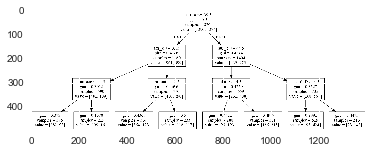

In [20]:
male_col_names = dec_tree_male.classes_
male_feature_names = male_subjects.columns[0:(male_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_male, "male_decision_tree(1.3).png", male_col_names, male_feature_names)

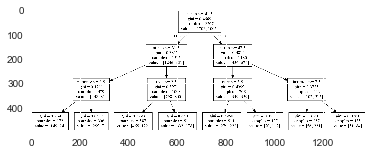

In [21]:
female_col_names = dec_tree_female.classes_
female_feature_names = female_subjects.columns[0:(female_subjects.shape[1] - 1)] # the features (attributes) used in the model
visualize_tree(dec_tree_female, "female_decision_tree.png", female_col_names, female_feature_names)

### <font color="green">Evaluating the performance of the gender models</font>

<font color = "red"><b><i>Explanations have been left out in this document. If one is interested in the explanation of the code and/or results. Please see consult our first assignment</i></b>

In [22]:
pred_male = dec_tree_male.predict(male_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(male_y_test, pred_male))

Accuracy score:  0.717800289436


In [23]:
pred_female = dec_tree_female.predict(female_x_test) # predicting 'dec' for data which the model has not seen yet
print("Accuracy score: ", metrics.accuracy_score(female_y_test, pred_female))

Accuracy score:  0.717872968981


In [24]:
print(metrics.classification_report(male_y_test, pred_male))

             precision    recall  f1-score   support

          0       0.80      0.61      0.69       361
          1       0.66      0.84      0.74       330

avg / total       0.74      0.72      0.71       691



In [25]:
print('percentage "dec = 0" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 0].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the male data set: ', round((male_subjects_shuffle.loc[male_subjects_shuffle.dec == 1].shape[0] / male_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the male data set:  50.68 %
percentage "dec = 1" in the male data set:  49.32 %


In [26]:
print(metrics.classification_report(female_y_test, pred_female))

             precision    recall  f1-score   support

          0       0.73      0.87      0.79       423
          1       0.69      0.46      0.55       254

avg / total       0.71      0.72      0.70       677



In [27]:
print('percentage "dec = 0" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 0].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")
print('percentage "dec = 1" in the female data set: ', round((female_subjects_shuffle.loc[female_subjects_shuffle.dec == 1].shape[0] / female_subjects_shuffle.dec.values.shape[0]) * 100, 2), "%")

percentage "dec = 0" in the female data set:  62.8 %
percentage "dec = 1" in the female data set:  37.2 %


## <font color = "red">----------------------------------------------------------------------------------------------------</font>

## <font color = "red">Start second homework assignment</font>

### 2.1 Modeling without sensitive attributes